In [2]:
import pandas as pd

df = pd.read_csv('../data\\fifa_world_cup_2022_tweets.csv')
df.head()

,Unnamed: 0,Date Created,Number of Likes,Source of Tweet,Tweet,Sentiment
0,0,2022-11-20 23:59:21+00:00,4,Twitter Web App,What are we drinking today @TucanTribe \n@MadB...,neutral
1,1,2022-11-20 23:59:01+00:00,3,Twitter for iPhone,Amazing @CanadaSoccerEN #WorldCup2022 launch ...,positive
2,2,2022-11-20 23:58:41+00:00,1,Twitter for iPhone,Worth reading while watching #WorldCup2022 htt...,positive
3,3,2022-11-20 23:58:33+00:00,1,Twitter Web App,Golden Maknae shinning bright\n\nhttps://t.co/...,positive
4,4,2022-11-20 23:58:28+00:00,0,Twitter for Android,"If the BBC cares so much about human rights, h...",negative


In [3]:
df.shape

(22524, 6)

In [4]:
df.describe()

,Unnamed: 0,Number of Likes
count,22524.000000,22524.000000
mean,11261.500000,23.822856
std,6502.263068,2128.018705
min,0.000000,0.000000
25%,5630.750000,0.000000
50%,11261.500000,0.000000
75%,16892.250000,2.000000
max,22523.000000,316867.000000


Non ci sono dati nulli 

In [5]:
df.isnull().sum()

Unnamed: 0         0
Date Created       0
Number of Likes    0
Source of Tweet    0
Tweet              0
Sentiment          0
dtype: int64

```Unnamed: 0``` è una colonna inutile, pertanto la elimino

In [6]:
del df['Unnamed: 0']

# Dataviz

Si visualizzano i dati del dataframe per scoprire caratteristiche e effettuare analisi

In [7]:

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords

sw = stopwords.words('english')
sw.remove('not')

plt.rcParams["figure.figsize"] = (15,7)

def show_wordcloud(data: list):
    str_for_wordcloud = ' '.join(data)
    
    wordcloud = WordCloud(stopwords=sw,
        background_color="black",
        min_font_size=23, 
        height=700,
        width=1200,
        include_numbers=True,
        relative_scaling=0.2,
        colormap='cividis').generate(str_for_wordcloud)
    
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()


La wordcloud è sporca, contiene molte parole che non c'entrano nulla come https, in seguito si effettuerà una pulizia dei tweets

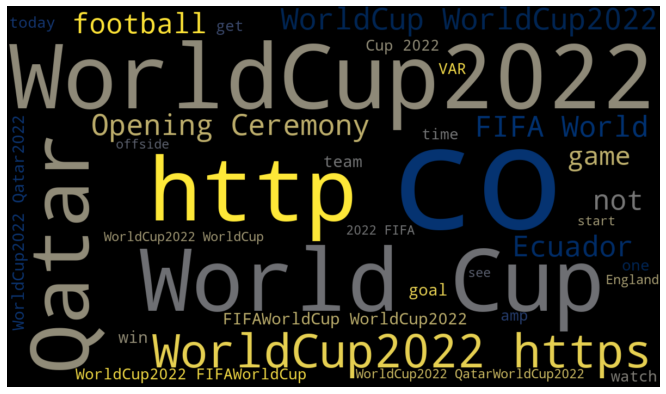

In [8]:
show_wordcloud(df.Tweet)

Il boxplot della colonna ```Number of Likes``` evidenzia parecchi outlier, uno raggiunge oltre 300K likes, si procederà eliminandoli

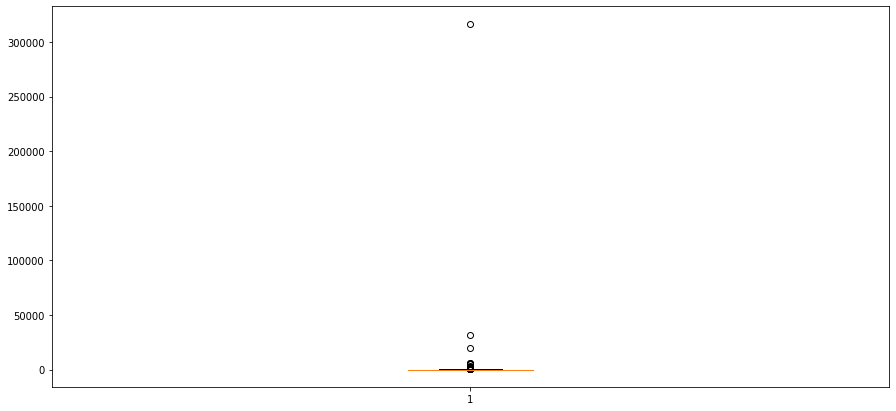

In [9]:
plt.boxplot(df['Number of Likes'])
plt.show()

In [10]:
df[df['Number of Likes'] > 300_000].Tweet[1287]

'I can’t express my gratitude and happiness for my participation in the biggest event of all times the World Cup in my country #Qatar with the talented Jung kook , thank you for everything\n#WorldCup \n#WorldCup2022 \n#JUNGKOOKxFIFA \n#JungkookAtFIFAWorldCup \n@BTS_twt \n@bts_bighit https://t.co/PebpCj9uN2'

La fonte da cui deriva il tweet per l'analisi non verrà considerata, verrà pertanto eliminata nella fase di preprocessing.
Possiamo però osservare che la moda di questa colonna è un tweet che è stato scritto da iPhone

In [11]:
df['Source of Tweet'].mode()

0    Twitter for iPhone
dtype: object

# Preprocessing

Eliminazione colonne che non verranno utilizizzate:
- ```Source of Tweet``` non viene utilizzata per l'analisi perchè l'obiettivo è quello di riconoscere se uno scritto esprime un sentimento positivo, neutrale o negativo
- ```Date Created``` non viene utilizzata per l'analisi perchè l'obiettivo è quello di prevedere quando viene scritto un tweet
- ```Number of Likes``` non viene utilizzata per l'analisi perchè non è presente una colonna che esprima il dislike, pertanto non si avrebbe un metro di paragone


In [12]:
del df['Source of Tweet']
del df['Date Created']
del df['Number of Likes']

Encoding colonna target

In [13]:
from sklearn.preprocessing import LabelEncoder

lb_sent = LabelEncoder()
df['Sentiment'] = lb_sent.fit_transform(df.Sentiment)
lb_sent.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

In [14]:
ref_dict = {k: v for k,v in zip(lb_sent.transform(lb_sent.classes_), lb_sent.classes_)}
ref_dict

{0: 'negative', 1: 'neutral', 2: 'positive'}

Pulizia dei Tweets

In [15]:
from nltk.tokenize import word_tokenize
import re, string

def clean_tweet(tweet):
    tweet = tweet.lower()
    tweet = tweet.replace('\n', ' ')
    tweet = re.sub("'", "", tweet) 
    tweet = re.sub("@[A-Za-z0-9_]+","", tweet)
    tweet = re.sub("#[A-Za-z0-9_]+","", tweet)
    tweet = re.sub(r'http\S+', '', tweet)
    tweet = re.sub('[()!?]', ' ', tweet)
    tweet = re.sub('\[.*?\]',' ', tweet)
    tweet = re.sub("[^a-z0-9]"," ", tweet)
    tweet = re.sub(' +', ' ', tweet)
    tweet = tweet.split()
    tweet = [w for w in tweet if not w in sw]
    tweet = " ".join(word for word in tweet)
    return tweet

In [16]:
df['clean_tweet'] = df.Tweet.apply(lambda x: clean_tweet(x))


Aggiungiamo la lunghezza della frase conteggiando il numero di parole

In [17]:
df['sentence_length'] = df['clean_tweet'].apply(lambda x: len(x.split()))
df.head()

,Tweet,Sentiment,clean_tweet,sentence_length
0,What are we drinking today @TucanTribe \n@MadB...,1,drinking today,2
1,Amazing @CanadaSoccerEN #WorldCup2022 launch ...,2,amazing launch video shows much face canada me...,27
2,Worth reading while watching #WorldCup2022 htt...,2,worth reading watching,3
3,Golden Maknae shinning bright\n\nhttps://t.co/...,2,golden maknae shinning bright,4
4,"If the BBC cares so much about human rights, h...",0,bbc cares much human rights homosexual rights ...,20


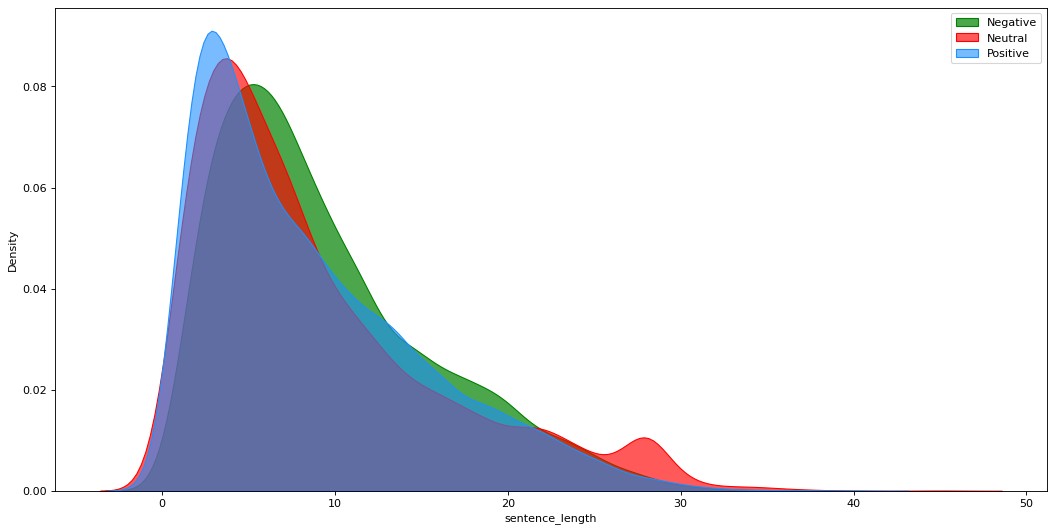

In [18]:
# Draw Plot
plt.figure(figsize=(16,8), dpi= 80)
sns.kdeplot(df.loc[df['Sentiment'] == 0, "sentence_length"], shade=True, color="g", label="Negative", alpha=.7)
sns.kdeplot(df.loc[df['Sentiment'] == 1, "sentence_length"], shade=True, color="r", label="Neutral", alpha=.65)
sns.kdeplot(df.loc[df['Sentiment'] == 2, "sentence_length"], shade=True, color="dodgerblue", label="Positive", alpha=.6)

# Decoration
plt.legend()
plt.show()

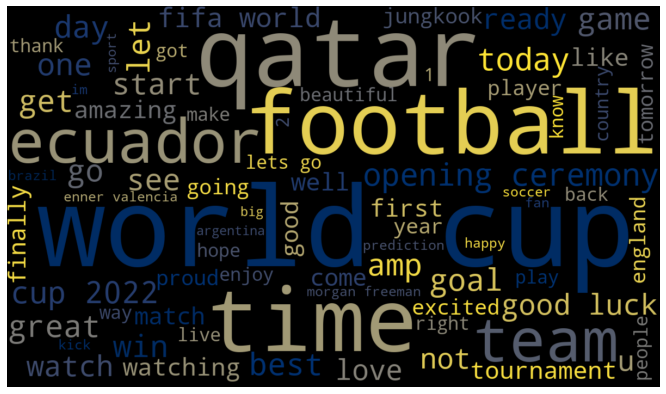

In [19]:
show_wordcloud(df[df.Sentiment == 2].clean_tweet) # positive

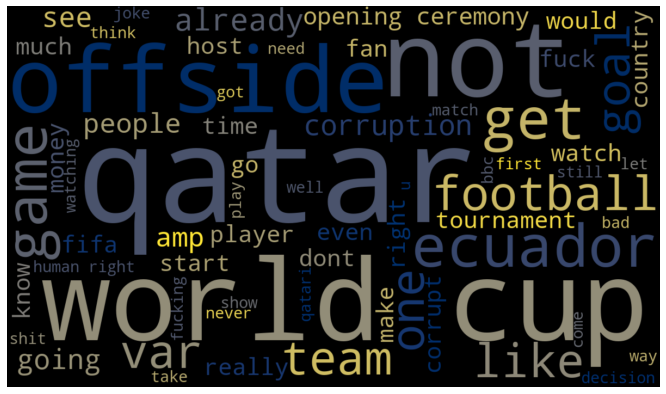

In [20]:
show_wordcloud(df[df.Sentiment == 0].clean_tweet) # negative

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

Tfidf = TfidfVectorizer(tokenizer=word_tokenize, min_df=10, max_df=0.90)
X = Tfidf.fit_transform(df.clean_tweet)
y = df.loc[:, 'Sentiment']

In [22]:

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [23]:
from sklearn.feature_extraction.text import CountVectorizer

Tfidf = CountVectorizer(tokenizer=word_tokenize, min_df=10, max_df=0.90)
X = Tfidf.fit_transform(df.clean_tweet)

X_df = pd.DataFrame(X.todense(), columns=sorted(Tfidf.vocabulary_))
X_df.head()

,0,00,000,00pm,1,10,100,1000,10am,10k,...,yet,yo,youll,young,youre,youth,youtube,youve,zakir,zero
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
df2 = df.copy()
df2.reset_index(inplace=True, drop=True)
X_df.reset_index(inplace=True, drop=True)

df2 = pd.concat([df2, X_df], axis = 1).set_index(df.index)
df2.head()

,Tweet,Sentiment,clean_tweet,sentence_length,0,00,000,00pm,1,10,...,yet,yo,youll,young,youre,youth,youtube,youve,zakir,zero
0,What are we drinking today @TucanTribe \n@MadB...,1,drinking today,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Amazing @CanadaSoccerEN #WorldCup2022 launch ...,2,amazing launch video shows much face canada me...,27,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Worth reading while watching #WorldCup2022 htt...,2,worth reading watching,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Golden Maknae shinning bright\n\nhttps://t.co/...,2,golden maknae shinning bright,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"If the BBC cares so much about human rights, h...",0,bbc cares much human rights homosexual rights ...,20,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
from sklearn.model_selection import train_test_split

X = df2.loc[:, df2.columns != 'Sentiment'].iloc[:, 2:]
y = df2.loc[:, 'Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.33)

In [32]:
from sklearn.metrics import accuracy_score

In [33]:
X_train

,sentence_length,0,00,000,00pm,1,10,100,1000,10am,...,yet,yo,youll,young,youre,youth,youtube,youve,zakir,zero
17515,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8182,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
304,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14959,11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11086,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11964,17,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21575,13,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5390,18,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
860,25,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0


In [34]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(X_train, y_train)


RandomForestClassifier()

TODO predict proba

In [35]:

pred = model.predict(X_test)
accuracy_score(y_test, pred)

0.6642001883492533

In [36]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)
pred = model.predict(X_test)
accuracy_score(y_test, pred)

0.7009282927485537

<AxesSubplot:>

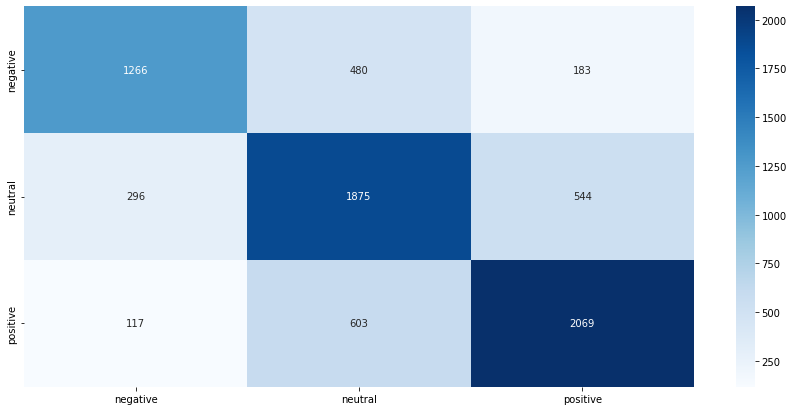

In [37]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_test, pred)
sns.heatmap(cf_matrix, 
             xticklabels=lb_sent.classes_,
             yticklabels = lb_sent.classes_, 
             annot=True, fmt='', cmap='Blues')
# cf_matrix.sum(axis=0).reshape(-1, 1)

# Hyperparameter tuning

In [38]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

pipe = Pipeline([('classifier' , RandomForestClassifier())])

param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : np.logspace(-4, 4, 20),
    'classifier__solver' : ['liblinear']},
    {'classifier' : [RandomForestClassifier()],
    'classifier__n_estimators' : list(range(10,101,10)),
    'classifier__max_features' : list(range(6,32,5))}
]

clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)

best_clf = clf.fit(X_train, y_train)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


KeyboardInterrupt: 